# ESN Notes

ESNs are RNNs that has an input layer, recurrent layer (reservoir), and an output layer.

The connection weights between the input layer and the reservoir layer are `fixed` (i.e. `input weights are fixed`).

The `output weights` are `trainable` and `obtained by solving a linear regression problem`.

<br>

## ESN Parameters
$u(t) \in \mathbb{R}^{D \times 1}$ is the input value at time $t$.

$x(t) \in \mathbb{R}^{N \times 1}$ is the reservoir at time $t$.

$y(t) \in \mathbb{R}^{M \times 1}$ is the output value at time $t$.

$W_{in} \in \mathbb{R}^{N \times D}$ is the input weight at time $t$.

$W_{res} \in \mathbb{R}^{N \times N}$ is the reservoir weight at time $t$.

$W_{out} \in \mathbb{R}^{M \times N}$ is the output weight at time $t$.

<br>

$$
x(t) = f(W_{\text{in}} u(t) + W_{\text{res}} x(t - 1))
$$

$$
y(t) = W_{\text{out}} x(t)
$$

<br>

The main hyperparameters are $\omega_{in}$, $\alpha$, and $\rho(W_{res})$:
1. $\omega_{in}$ is an input-scaling parameter. Its elements are randomly initialized from a uniform distribution in [$-\omega_{in}$, $\omega_{in}$].
2. $\alpha$ is a sparsity parameter of $W_{res}$, denoting the proportion of nonzero elements in a matrix.
3. $\rho(W_{res})$ is the spectral radius parameter (the largest eigen-value in absolute value) of $W_{res}$. $W_{res}$ is initialized from a matrix $W$, where the elements of $W$ are generated randomly in [−1, 1] and $\lambda_{max}(W)$ is the largest eigenvalue
$$
W_{res} = \rho(W_{res}) \cdot \frac{W}{\lambda_{\max}(W)}.
$$

`The only weights that are trained are the output weights `$W_{out}$. They can be calculated to get the closed-form solution using algorithms like ridge regression (modified cost fxn of linear regression). Assume that the internal states and desired outputs are stored in $X$ and $Y$. By training to find a solution to the least squares problem, the calculation formula of the readout weights $W_{out}$ is

$$
\min_{W_{\text{out}}} \| W_{\text{out}} X - Y \|_2^2, \quad W_{\text{out}} = Y \cdot X^{-1}
$$

Another important characteristic of ESNs is the Echo State Property (ESP). It basically says that the reservoir states should asymptotically only depend on the driving input signal. This means that the state is an "echo" of the input and the influence of the initial conditions should gradually diminish.

Every echo state is uniquely determined for every input sequence. This implies that the nearby echo states have similar input histories.

## ESP (Echo State Property)
A network with state transition equation $F$ has the ESP if for each input sequence $U = [u(1), u(2), ..., u(N)]$ and all pairs of initial states $x$ and $x'$, it could hold the condition

$$
\| F(U, x) - F(U, x') \| \to 0 \quad \text{as} \quad N \to \infty \tag{5}
$$

The existence of ESP is verified by a necessary condition and a sufficient condition

$$
\textit{echo state property} \Rightarrow \rho(W_{\text{res}}) < 1
$$

$$
\bar{\sigma}(W_{\text{res}}) = \| W \|_2 < 1 \Rightarrow \textit{echo state property}. \tag{6}
$$

These two conditions are used for reservoir initialization.

## STM (Short-Term Memory)
STM denotes the memory effects connected with the transient activation dynamics of networks. MC is its quantitative measure, calculated by the coefficient of readout weight:

$$
\text{MC} = \sum_{k=1}^{\infty} \text{MC}_k, \quad
\text{MC}_k = \max_{W_{\text{out}}^k} d[W_{\text{out}}^k](u(n - k), y_k(n))
$$



In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ESN(nn.Module):
    """docstring for ESN"""
    def __init__(self, input_size, reservoir_size, output_size, spectral_radius=0.1, sparsity=0.1, input_scaling = 1, reg=1e-6):
        super().__init__()
        self.reservoir_size = reservoir_size
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.input_scaling = input_scaling
        self.reg = reg

        # Need to randomize/initialize w_in and w_res
        self.W_in = nn.Parameter((2*torch.rand(reservoir_size, input_size) - 1)*input_scaling, requires_grad=False) # NxD matrix/tensor (make it range from [-1,1])
        self.W_res = nn.Parameter(self._intialize_reservoir(), requires_grad=False)
        self.W_out = None # LxN matrix/tensor
        self.activation = torch.tanh # activation function

    def _intialize_reservoir(self):
        # Step 1: Create a random weight matrix
        W = torch.rand(reservoir_size, reservoir_size, dtype=torch.float32) - 0.5

        # Step 2: Apply sparsity (set some elements to zero)
        mask = torch.rand(reservoir_size, reservoir_size) > self.sparsity  # Keep `1-sparsity` fraction
        W *= mask

        # Step 3: Compute spectral radius
        eigvals = torch.linalg.eigvals(W)  # Get eigenvalues
        eigvals = eigvals.real  # Take only real part if complex numbers appear
        radius = torch.max(torch.abs(eigvals))  # Get maximum absolute eigenvalue

        # Step 4: Normalize spectral radius
        if radius > 0:  # Avoid division by zero
            W *= self.spectral_radius / radius

        return W.clone().detach()  # Properly return without computational graph

    # Automatically called by PyTorch (input is u and output is y)
    def forward(self, u):
        """
        Computes the reservoir states.
        x: (batch_size, seq_len, input_size)
        Returns:
        states: (batch_size, seq_len, reservoir_size)
        """
        batch_size, seq_len, _ = u.shape
        x = torch.zeros(batch_size, self.reservoir_size)
        states = []
        for t in range(seq_len):
            x = self.activation(torch.matmul(u[:, t, :], self.W_in.T) + torch.matmul(x, self.W_res.T)) # Calculate new state
            states.append(x.unsqueeze(1)) # States store the reservoir states at each time step (1xN matrix) + add time dimension

        return torch.cat(states, dim=1) # stacks all states along time dimension

    def train_readout(self, U, Y):
        """
        Trains the readout layer using ridge regression.
        X: (batch_size, seq_len, reservoir_size)
        Y: (batch_size, seq_len, output_size)
        """
        U = U.reshape(-1, self.reservoir_size)
        Y = Y.reshape(-1, Y.shape[-1])

        U_T = U.T
        I = torch.eye(self.reservoir_size) * self.reg
        self.W_out = torch.linalg.solve(U_T @ U + I, U_T @ Y)


    def predict(self, U):
        """
        Computes predictions using trained readout weights.
        """
        U = U.reshape(-1, self.reservoir_size)
        return U @ self.W_out


Train Predictions Shape: torch.Size([500, 1])
Test Predictions Shape: torch.Size([500, 1])


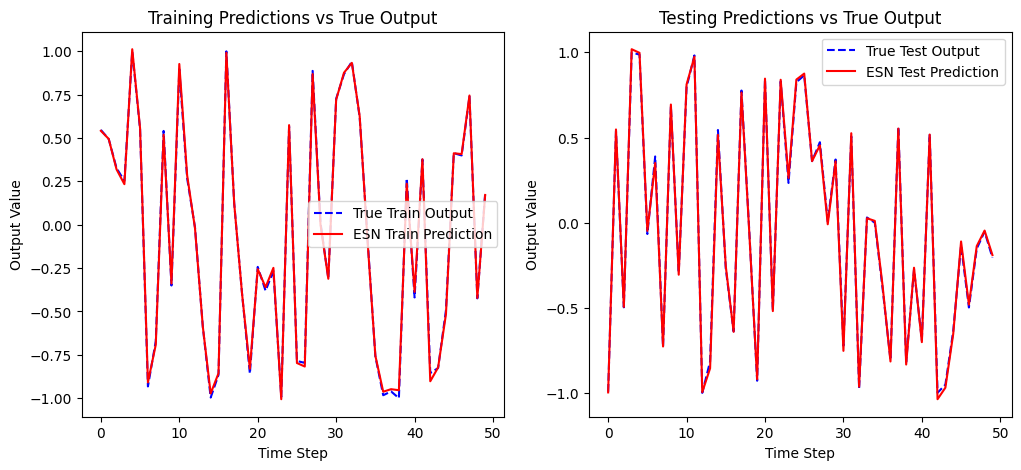

In [4]:
# Example Usage:
input_size = 1
reservoir_size = 100
output_size = 1

# Initialize ESN
esn = ESN(input_size, reservoir_size, output_size)

# Generate dummy input data
seq_len = 50
batch_size = 10

# Train Data
X_train = torch.randn(batch_size, seq_len, input_size)
Y_train = torch.sin(X_train.sum(dim=2, keepdim=True))  # Some nonlinear target function

# Test Data (Different from training to check generalization)
X_test = torch.randn(batch_size, seq_len, input_size)
Y_test = torch.sin(X_test.sum(dim=2, keepdim=True))  # True function on test set

# Collect reservoir states for training and testing
reservoir_states_train = esn(X_train)
reservoir_states_test = esn(X_test)  # Ensure test inputs go through ESN

# Train readout layer
esn.train_readout(reservoir_states_train, Y_train)

# Make predictions on train and test sets
train_preds = esn.predict(reservoir_states_train)
test_preds = esn.predict(reservoir_states_test)

print("Train Predictions Shape:", train_preds.shape)  # Expected: (batch_size * seq_len, output_size)
print("Test Predictions Shape:", test_preds.shape)  # Expected: (batch_size * seq_len, output_size)

# Convert tensors to NumPy for plotting
train_preds_np = train_preds.detach().cpu().numpy().reshape(batch_size, seq_len, output_size)
test_preds_np = test_preds.detach().cpu().numpy().reshape(batch_size, seq_len, output_size)
Y_train_np = Y_train.detach().cpu().numpy().reshape(batch_size, seq_len, output_size)
Y_test_np = Y_test.detach().cpu().numpy().reshape(batch_size, seq_len, output_size)

# Plot train and test predictions
plt.figure(figsize=(12, 5))

# Train Plot
plt.subplot(1, 2, 1)
plt.plot(range(seq_len), Y_train_np[0, :, 0], label="True Train Output", linestyle="dashed", color="blue")
plt.plot(range(seq_len), train_preds_np[0, :, 0], label="ESN Train Prediction", color="red")
plt.xlabel("Time Step")
plt.ylabel("Output Value")
plt.title("Training Predictions vs True Output")
plt.legend()

# Test Plot
plt.subplot(1, 2, 2)
plt.plot(range(seq_len), Y_test_np[0, :, 0], label="True Test Output", linestyle="dashed", color="blue")
plt.plot(range(seq_len), test_preds_np[0, :, 0], label="ESN Test Prediction", color="red")
plt.xlabel("Time Step")
plt.ylabel("Output Value")
plt.title("Testing Predictions vs True Output")
plt.legend()

plt.show()